In [168]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import pickle
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


# load train dataset
trainX, trainy = load_dataset('dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('dataset/val/')
# save arrays to one file in compressed format
savez_compressed('dataset.npz', trainX, trainy, testX, testy)

>loaded 10 examples for class: George_HW_Bush
>loaded 5 examples for class: Jose_Luis
>loaded 7 examples for class: Leonardo_DiCaprio
>loaded 12 examples for class: Meryl_Streep
>loaded 9 examples for class: Michael_Jackson
>loaded 5 examples for class: Patricia
>loaded 41 examples for class: Unknown
(89, 160, 160, 3) (89,)
>loaded 3 examples for class: George_HW_Bush
>loaded 3 examples for class: Jose_Luis
>loaded 2 examples for class: Leonardo_DiCaprio
>loaded 3 examples for class: Meryl_Streep
>loaded 3 examples for class: Michael_Jackson
>loaded 3 examples for class: Patricia
>loaded 22 examples for class: Unknown


In [169]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('dataset-clf-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (89, 160, 160, 3) (89,) (39, 160, 160, 3) (39,)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(89, 128)
(39, 128)


In [170]:
# load face embeddings
data = load('dataset-clf-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [213]:
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras

# Define model
how_many_classes = 7
# fix random seed for reproducibility
np.random.seed(7)

model_clf = Sequential([
    Dense(100, input_dim = 128, activation = "relu", name = "first_FC"),
    Dense(20, activation = "relu", name = "second_FC"),
    Dense(how_many_classes, activation = "softmax", name = "third_FC")
], name = "nn_clf")

# Model compile
model_clf.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
# 3) Fit model
history = model_clf.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)

# 4) Save for future inference
model_clf.save("nn_clf.h5")

Train on 89 samples, validate on 39 samples
Epoch 1/100
89/89 [==============================] - 0s 2ms/step - loss: 1.9269 - accuracy: 0.1798 - val_loss: 1.8965 - val_accuracy: 0.4103
Epoch 2/100
89/89 [==============================] - 0s 134us/step - loss: 1.8842 - accuracy: 0.3933 - val_loss: 1.8604 - val_accuracy: 0.7179
Epoch 3/100
89/89 [==============================] - 0s 146us/step - loss: 1.8416 - accuracy: 0.6517 - val_loss: 1.8237 - val_accuracy: 0.7179
Epoch 4/100
89/89 [==============================] - 0s 190us/step - loss: 1.7990 - accuracy: 0.7079 - val_loss: 1.7844 - val_accuracy: 0.7436
Epoch 5/100
89/89 [==============================] - 0s 168us/step - loss: 1.7538 - accuracy: 0.7303 - val_loss: 1.7423 - val_accuracy: 0.7692
Epoch 6/100
89/89 [==============================] - 0s 146us/step - loss: 1.7042 - accuracy: 0.7753 - val_loss: 1.6969 - val_accuracy: 0.7949
Epoch 7/100
89/89 [==============================] - 0s 224us/step - loss: 1.6531 - accuracy: 0.7865

89/89 [==============================] - 0s 191us/step - loss: 0.0452 - accuracy: 1.0000 - val_loss: 0.0992 - val_accuracy: 1.0000
Epoch 58/100
89/89 [==============================] - 0s 415us/step - loss: 0.0428 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 1.0000
Epoch 59/100
89/89 [==============================] - 0s 191us/step - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 1.0000
Epoch 60/100
89/89 [==============================] - 0s 168us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 1.0000
Epoch 61/100
89/89 [==============================] - 0s 213us/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 1.0000
Epoch 62/100
89/89 [==============================] - 0s 179us/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 1.0000
Epoch 63/100
89/89 [==============================] - 0s 202us/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 1.0000
Epoch

In [214]:
# evaluate the model
train_loss, train_acc = model_clf.evaluate(newTrainX, trainy, verbose=1)
test_loss, test_acc = model_clf.evaluate(newTestX, testy, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

39/39 [==============================] - 0s 128us/step
Train: 0.000, Test: 0.070
Train: 1.000, Test: 0.974


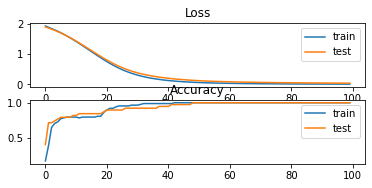

In [215]:
# plot loss during training
pyplot.subplot(311)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(312)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [216]:
# Predict the probability across all output classes
yhat = model_clf.predict_classes(newTestX)
yhat_prob = model_clf.predict_proba(newTestX)
print(yhat)
print(yhat_prob)

[0 0 0 1 1 1 2 2 3 3 3 4 4 4 5 5 5 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6]
[[1.00000000e+00 0.00000000e+00 1.44379746e-27 2.80173128e-33
  0.00000000e+00 6.34738756e-34 2.26343965e-25]
 [1.00000000e+00 0.00000000e+00 2.13451066e-27 3.09259661e-34
  0.00000000e+00 4.67639490e-35 1.86145082e-24]
 [1.00000000e+00 0.00000000e+00 4.78067150e-26 3.48781046e-32
  0.00000000e+00 6.08665039e-32 1.24912918e-22]
 [0.00000000e+00 1.00000000e+00 8.02179289e-28 2.95099119e-24
  4.02567099e-17 1.70752751e-36 2.79441117e-24]
 [0.00000000e+00 1.00000000e+00 1.89779873e-28 2.63889035e-25
  1.26850619e-20 0.00000000e+00 1.29524747e-29]
 [0.00000000e+00 1.00000000e+00 1.92520727e-29 5.13891943e-26
  4.02470851e-22 0.00000000e+00 2.46014415e-28]
 [2.10736823e-33 1.76277076e-30 1.00000000e+00 1.09205916e-32
  5.82656890e-30 0.00000000e+00 1.39710283e-29]
 [2.06811333e-34 2.84243378e-26 1.00000000e+00 6.18344471e-32
  1.49850812e-27 0.00000000e+00 3.52127047e-33]
 [1.59193228e-34 1.58756023e-26 2.99353

Predicted: Unknown (94.698)
Expected: Unknown


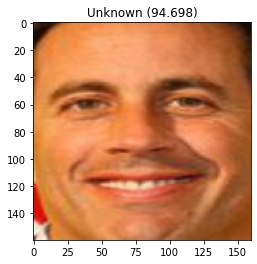

In [217]:
# load faces
data = load('dataset.npz')
testX_faces = data['arr_2']

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model_clf.predict_classes(samples)
yhat_prob = model_clf.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

Predicted: George_HW_Bush (99.430)
Expected: George_HW_Bush


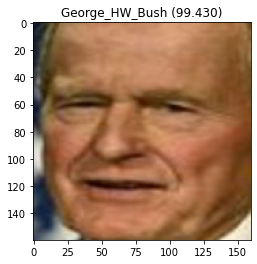

Predicted: George_HW_Bush (99.148)
Expected: George_HW_Bush


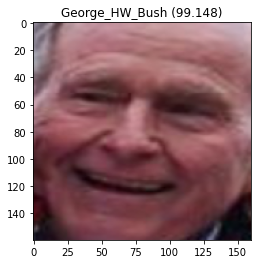

Predicted: George_HW_Bush (98.796)
Expected: George_HW_Bush


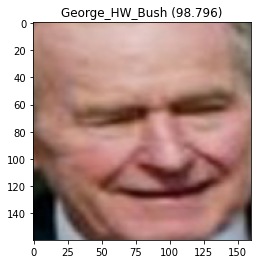

Predicted: Jose_Luis (96.203)
Expected: Jose_Luis


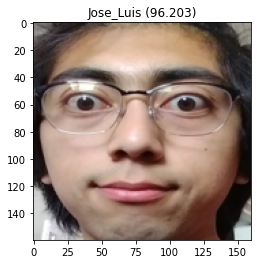

Predicted: Jose_Luis (99.017)
Expected: Jose_Luis


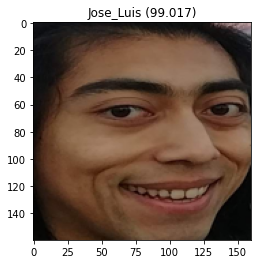

Predicted: Jose_Luis (99.100)
Expected: Jose_Luis


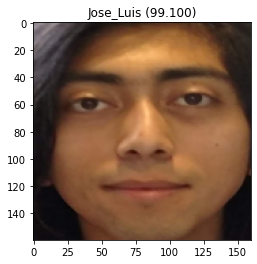

Predicted: Leonardo_DiCaprio (99.361)
Expected: Leonardo_DiCaprio


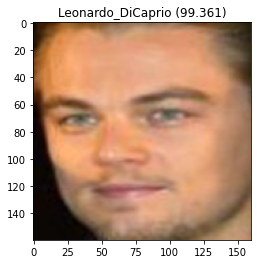

Predicted: Leonardo_DiCaprio (98.808)
Expected: Leonardo_DiCaprio


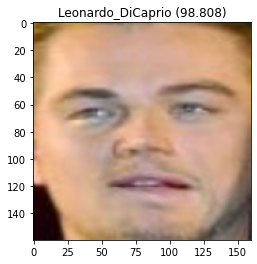

Predicted: Meryl_Streep (99.466)
Expected: Meryl_Streep


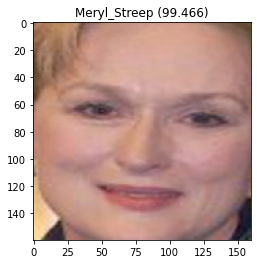

Predicted: Meryl_Streep (99.396)
Expected: Meryl_Streep


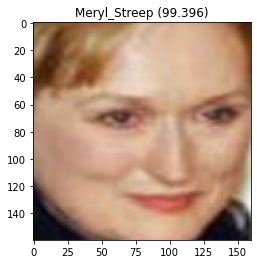

Predicted: Meryl_Streep (94.513)
Expected: Meryl_Streep


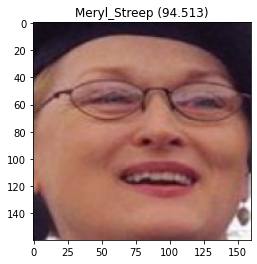

Predicted: Michael_Jackson (99.215)
Expected: Michael_Jackson


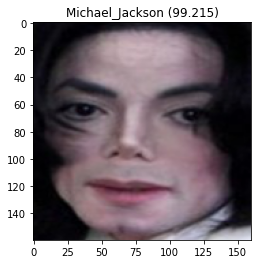

Predicted: Michael_Jackson (98.643)
Expected: Michael_Jackson


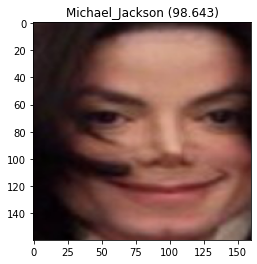

Predicted: Michael_Jackson (98.229)
Expected: Michael_Jackson


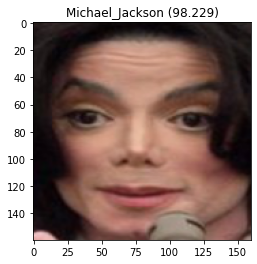

Predicted: Patricia (71.385)
Expected: Patricia


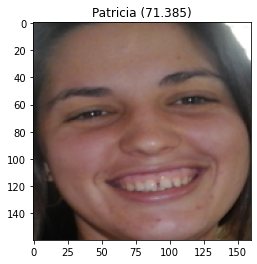

Predicted: Patricia (84.591)
Expected: Patricia


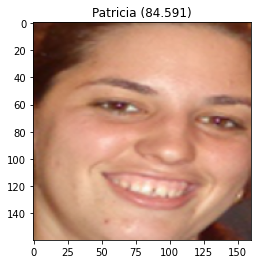

Predicted: Patricia (89.627)
Expected: Patricia


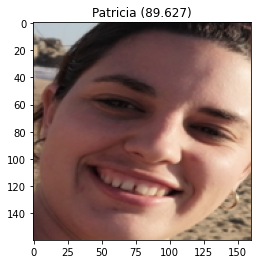

Predicted: Unknown (99.658)
Expected: Unknown


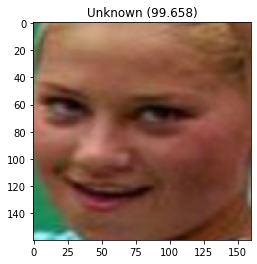

Predicted: Unknown (97.788)
Expected: Unknown


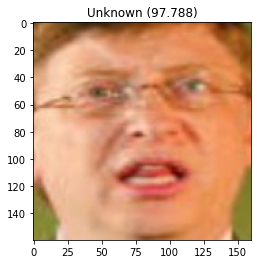

Predicted: Unknown (97.759)
Expected: Unknown


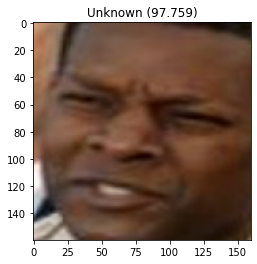

Predicted: Unknown (65.239)
Expected: Unknown


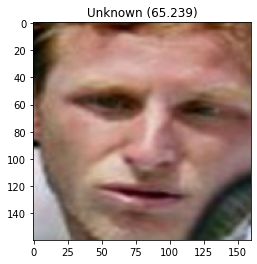

Predicted: Unknown (99.587)
Expected: Unknown


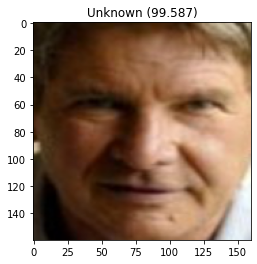

Predicted: Unknown (99.872)
Expected: Unknown


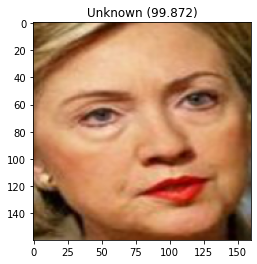

Predicted: Unknown (99.922)
Expected: Unknown


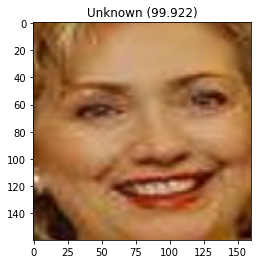

Predicted: Unknown (96.391)
Expected: Unknown


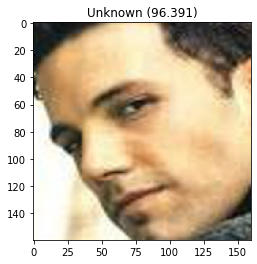

Predicted: Unknown (93.158)
Expected: Unknown


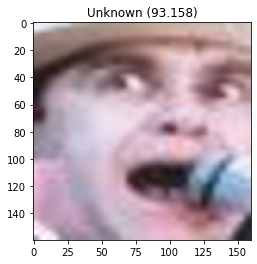

Predicted: Unknown (99.077)
Expected: Unknown


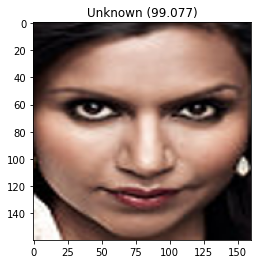

Predicted: Unknown (96.321)
Expected: Unknown


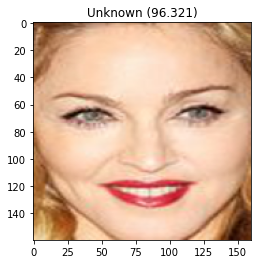

Predicted: Unknown (98.965)
Expected: Unknown


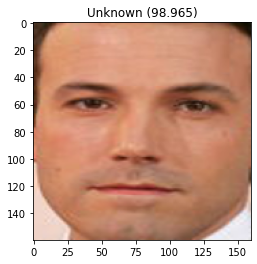

Predicted: Unknown (94.698)
Expected: Unknown


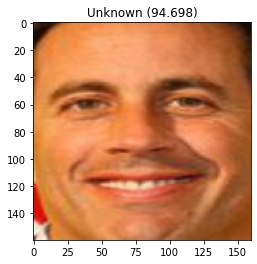

Predicted: Unknown (99.847)
Expected: Unknown


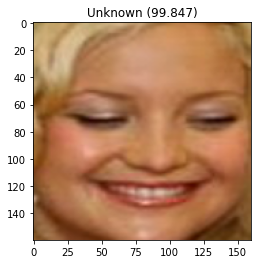

Predicted: Unknown (99.101)
Expected: Unknown


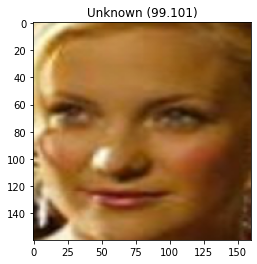

Predicted: Unknown (99.739)
Expected: Unknown


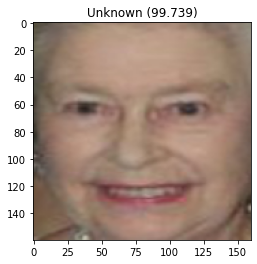

Predicted: Unknown (99.139)
Expected: Unknown


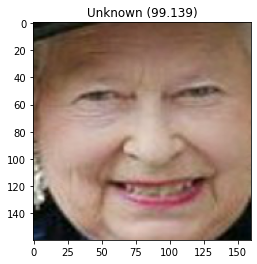

Predicted: Unknown (96.511)
Expected: Unknown


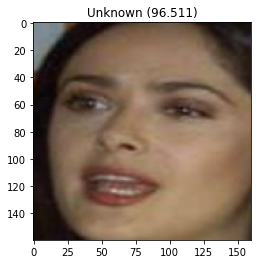

Predicted: Unknown (95.923)
Expected: Unknown


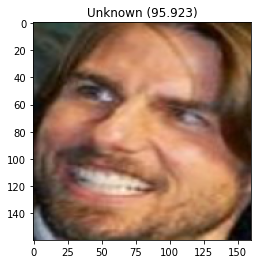

Predicted: Unknown (99.008)
Expected: Unknown


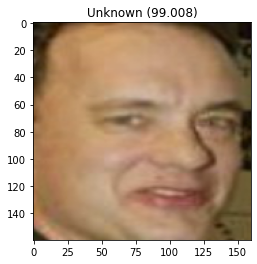

Predicted: Unknown (99.791)
Expected: Unknown


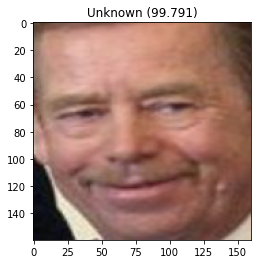

Predicted: Unknown (99.107)
Expected: Unknown


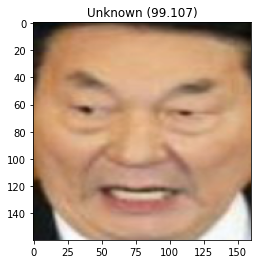

In [218]:
#Define True Positive (TP) and False Positive (FP)
TP = []
FP = []

#Store predicted classes and probabilities
prediction = []
probabilities = []
classes = []

# Predict every face in the test set and compare with the expected label
for i in range(len(testX_faces)):
    face_pixels = testX_faces[i]
    face_emb = testX[i]
    face_class = testy[i]
    face_name = out_encoder.inverse_transform([testy[i]])
    
    # prediction for the face
    #sample = expand_dims(testX[i], axis=0)
    sample = face_emb.reshape(1, 128)
    yhat_class = model_clf.predict_classes(sample)
    prediction.append(yhat_class)
    yhat_prob = model_clf.predict_proba(sample)
    probabilities.append(yhat_prob)
    
    #Compare with expected label
    if yhat_class == face_class:
        TP.append(i)
    else:
        FP.append(i)
        
     # get name
    all_class_index = yhat_class[0]
    all_class_probability = yhat_prob[0,all_class_index] * 100
    predict_all_names = out_encoder.inverse_transform(yhat_class)
    classes.append(predict_all_names)
    print('Predicted: %s (%.3f)' % (predict_all_names[0], all_class_probability))
    print('Expected: %s' % face_name[0])

    # plot for fun
    pyplot.imshow(face_pixels)
    title_2 = '%s (%.3f)' % (predict_all_names[0], all_class_probability)
    pyplot.title(title_2)
    pyplot.show()
    
with open('labels2_lfw.txt', 'wb') as fp:
    pickle.dump(prediction, fp)

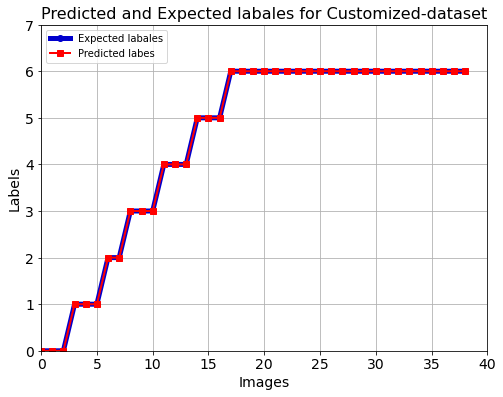

In [230]:
import matplotlib.pyplot as plt

#Plotting labels
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax1.plot(testy, color="mediumblue", linestyle="-", marker="o", linewidth=5, label="Expected labales")
ax1.plot(prediction, color="r", linestyle="-", marker="s", linewidth=2, label="Predicted labes")

ax1.set_title('Predicted and Expected labales for Customized-dataset', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper left')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Images', fontsize=14)
plt.ylabel('Labels', fontsize=14)
plt.xlim(0, 40)
plt.ylim(0, 7)
plt.grid(b=None, which='major', axis='both')
plt.savefig('predicted vs. expected.png')
plt.show()

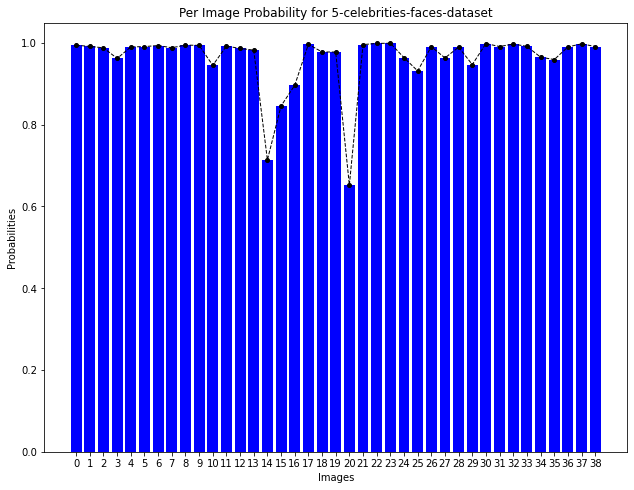

In [231]:
import numpy as np

prob = []
for i in probabilities:
    prob.append(max(max(i)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

labels = []
for i in range(len(prob)):
    if testy[i] != testy[i-1]:
        labels.append(classes[i])
        
ax.set_xlabel("Images")
ax.set_ylabel('Probabilities')
ax.set_title("Per Image Probability for 5-celebrities-faces-dataset")

colors = np.random.rand(len(labels),3)

for i in range(len(prob)):
           ax.bar(i, prob[i], color='b')

plt.xticks(range(len(prob)), range(len(prob)), fontsize=10, rotation=0)
ax.plot(range(len(prob)), prob[0:], color='black', marker='o', linestyle='dashed', linewidth = 1, markersize = 4)
fig.tight_layout(pad=5) 

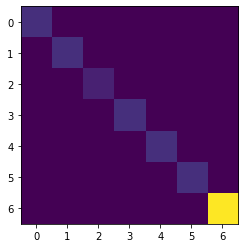

In [235]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(testy, prediction)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel('True Labels')
plt.imshow(matrix)
plt.show()

In [226]:
# Write labels in txt file for future inference
import pickle

newlist = []
newlist2= []
newlist3 = []

for i in range(len(prediction)):
    if prediction[i][0] != prediction[i-1][0]:
        newlist.append(prediction[i][0])
        
for i in range(len(newlist)):
    a = np.asarray(newlist[i])
    b = expand_dims(a, axis=0)
    #print(b.shape)
    c = out_encoder.inverse_transform(b)
    newlist2.append(c)

for i in range(len(newlist2)):
    newlist3.append(newlist2[i][0])

# Save to txt 
with open('labels_dataset.txt', 'wb') as fp:
    pickle.dump(newlist3, fp)

with open('labels_code_dataset.txt', 'wb') as fp:
    pickle.dump(newlist, fp)
    
# Check if they were properly saved
with open ('labels_dataset.txt', 'rb') as fp:
    itemlist2 = pickle.load(fp)

with open ('labels_code_dataset.txt', 'rb') as fp:
    itemlist3 = pickle.load(fp)

for i in range(len(newlist)):
    print(itemlist2[i])
    print(itemlist3[i])

George_HW_Bush
0
Jose_Luis
1
Leonardo_DiCaprio
2
Meryl_Streep
3
Michael_Jackson
4
Patricia
5
Unknown
6
